In [117]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.metrics import silhouette_score

import random

random.seed(42)

In [118]:
import requests, zipfile, io
import pandas as pd

# Download from remote URL
data_uri = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"

r = requests.get(data_uri)

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/uci_electricity/")

# Load as pandas dataframe
df = pd.read_csv(
    "data/uci_electricity/LD2011_2014.txt", delimiter=";", decimal=','
).rename(columns={"Unnamed: 0": "date"}).set_index("date")
df.index = pd.to_datetime(df.index)


In [119]:
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


<Axes: xlabel='date'>

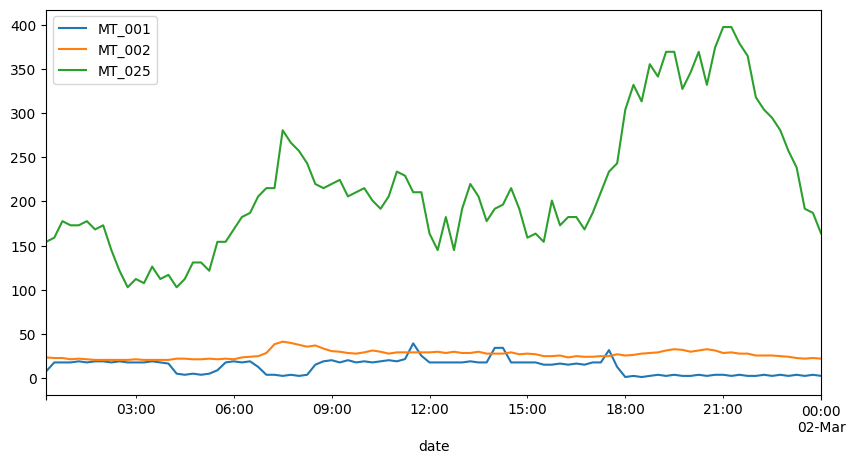

In [121]:
df_test = df.loc['2012-03-01 00:15:00':'2012-03-02 00:00:00'][['MT_001','MT_002','MT_025']]

df_test.plot(figsize=(10,5))

In [122]:
data2011 = df.loc['2011-01-01 00:00:00':'2011-12-31 00:00:00']
data2012 = df.loc['2012-01-01 00:00:00':'2012-12-31 00:00:00']
data2013 = df.loc['2013-01-01 00:00:00':'2013-12-31 00:00:00']
data2014 = df.loc['2014-01-01 00:00:00':'2014-12-31 00:00:00']

In [123]:
data2013.shape

(34945, 370)

In [124]:
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [125]:
clients = data2013.columns
clients_no_demand = clients[data2013.mean()==0]
data_13_14 = pd.concat([data2013,data2014], axis=0)
data_13_14.drop(clients_no_demand,axis=1,inplace=True)

In [126]:
data_13_14.shape

(69890, 349)

In [127]:
data = data_13_14.copy()

In [128]:
data['hour'] = data.index.strftime('%H:%M')


In [129]:
data.sample(15)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
date,,,,,,,,,,,,,,,,,,,,,
2013-10-14 15:45:00,15.228426,27.027027,1.737619,83.333333,47.560976,175.595238,2.261164,222.222222,41.958042,65.591398,...,86400.0,4641.350211,6636.363636,91.264668,6.436513,627.743635,148.580968,864.369501,16648.648649,15:45
2014-01-23 04:30:00,2.538071,22.759602,1.737619,89.430894,63.414634,145.833333,3.957038,202.020202,40.209790,44.086022,...,13100.0,565.400844,1431.818182,18.252934,8.191925,536.435470,78.464107,675.953079,12864.864865,04:30
2013-03-12 02:30:00,1.269036,22.759602,2.606429,69.105691,35.365854,136.904762,3.957038,181.818182,29.720280,66.666667,...,12900.0,582.278481,886.363636,14.341591,7.606788,610.184372,121.869783,750.733138,18313.513514,02:30
2013-07-31 22:00:00,1.269036,39.829303,1.737619,148.373984,54.878049,264.880952,3.391747,303.030303,43.706294,39.784946,...,119900.0,4046.413502,7840.909091,161.668840,42.129901,668.129939,196.994992,1121.700880,18551.351351,22:00
2013-09-30 05:15:00,17.766497,23.470839,1.737619,91.463415,26.829268,104.166667,2.261164,212.121212,31.468531,27.956989,...,11900.0,835.443038,863.636364,23.468057,7.606788,510.096576,43.405676,695.014663,15697.297297,05:15
2014-11-14 03:15:00,2.538071,16.358464,1.737619,93.495935,46.341463,119.047619,3.957038,205.387205,50.699301,41.935484,...,13200.0,793.248945,1045.454545,27.379400,7.606788,625.109745,96.828047,741.935484,13837.837838,03:15
2014-03-22 10:30:00,0.000000,27.738265,1.737619,154.471545,53.658537,175.595238,3.957038,249.158249,47.202797,39.784946,...,46900.0,1607.594937,3113.636364,82.138201,3.510825,451.273047,40.066778,743.401760,15621.621622,10:30
2014-05-24 17:15:00,0.000000,27.738265,1.737619,128.048780,31.707317,187.500000,2.261164,222.222222,29.720280,37.634409,...,69400.0,3244.725738,5704.545455,112.125163,5.851375,517.120281,48.414023,782.258065,19513.513514,17:15
2014-06-24 01:45:00,2.538071,21.337127,1.737619,97.560976,35.365854,136.904762,3.957038,202.020202,40.209790,39.784946,...,13100.0,708.860759,909.090909,70.404172,15.213575,697.102722,136.894825,731.671554,19297.297297,01:45


In [130]:
grouped_data = data.groupby('hour')

average_curves = grouped_data.agg('mean')

average_curves.shape

(96, 349)

<Axes: xlabel='hour'>

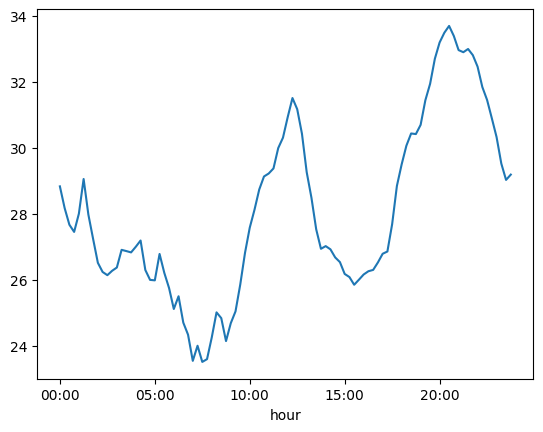

In [131]:
average_curves['MT_032'].plot()

In [132]:
average_curves_normalized = average_curves/average_curves.mean()
average_curves_normalized

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00,0.962886,0.926618,0.992692,1.140397,1.187250,1.009738,1.169629,0.947080,0.984560,0.949023,...,0.414050,0.747753,0.560944,0.429703,0.471136,1.358005,1.214095,1.170265,0.974179,0.991814
00:15,0.947092,0.919295,0.977720,1.098834,1.131877,0.945817,1.118808,0.909145,0.953945,0.923977,...,0.414083,0.661970,0.411660,0.375329,0.421270,1.366033,1.184536,1.222326,0.969239,1.000066
00:30,0.959832,0.880826,0.976500,1.061286,1.090481,0.905062,1.081616,0.880642,0.931488,0.908132,...,0.386493,0.561286,0.394701,0.344415,0.386196,1.312672,1.177598,1.210246,0.947894,1.008033
00:45,0.958826,0.877351,0.971617,1.029863,1.054028,0.867892,1.056587,0.854908,0.907105,0.884517,...,0.337490,0.499200,0.352319,0.294964,0.377070,1.245491,1.156246,1.189570,0.937797,1.007129
01:00,0.956144,0.842009,0.953308,0.975603,1.024200,0.822277,1.031441,0.829916,0.888039,0.868671,...,0.318548,0.422239,0.341801,0.288698,0.369194,1.292439,1.149154,1.167611,0.931186,1.006250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45,0.997045,0.955679,1.038141,1.348346,1.370171,1.276590,1.319272,1.104901,1.161197,1.096975,...,0.744645,1.202843,1.020263,0.922014,1.303881,1.418337,1.265293,1.206074,1.006073,1.014007
23:00,1.024201,0.957868,1.009456,1.294477,1.353065,1.237994,1.297752,1.078081,1.136677,1.073412,...,0.645756,1.090971,0.961610,0.892796,1.212447,1.406699,1.268049,1.187403,1.001178,1.005411
23:15,1.031576,0.955019,1.003964,1.239607,1.325380,1.179291,1.260793,1.045090,1.094878,1.030450,...,0.568529,0.989309,0.892707,0.758645,1.034421,1.393673,1.252318,1.175575,1.008870,0.992694


<Axes: xlabel='hour'>

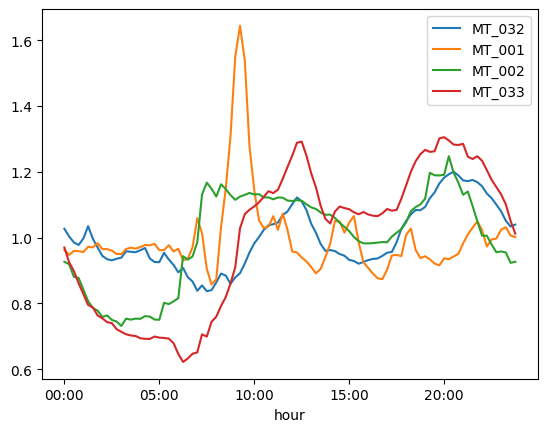

In [133]:
average_curves_normalized[['MT_032','MT_001','MT_002','MT_033']].plot()

In [134]:
X = average_curves_normalized.copy()
X=np.array(X.T)

c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

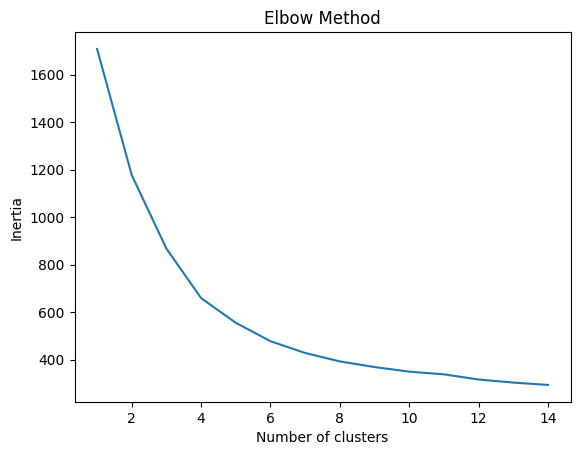

<Figure size 1500x500 with 0 Axes>

In [135]:
inertia = []

for i in range(1, 15):

    kmeans = KMeans(n_clusters=i, random_state=0)

    kmeans.fit(X)

    inertia.append(kmeans.inertia_)

 

plt.plot(range(1, 15), inertia)

plt.title('Elbow Method')

plt.xlabel('Number of clusters')

plt.ylabel('Inertia')
plt.figure(figsize=(15,5))
plt.show()

c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

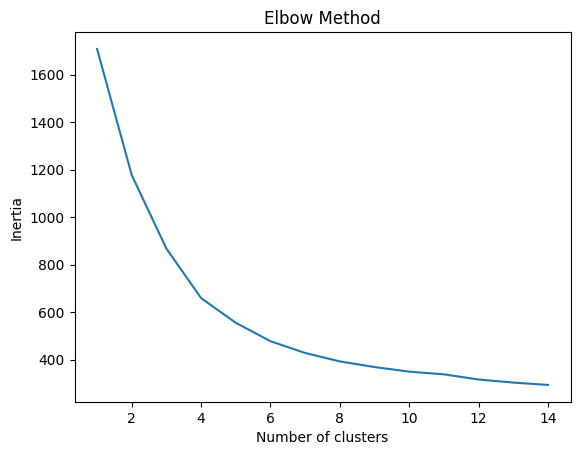

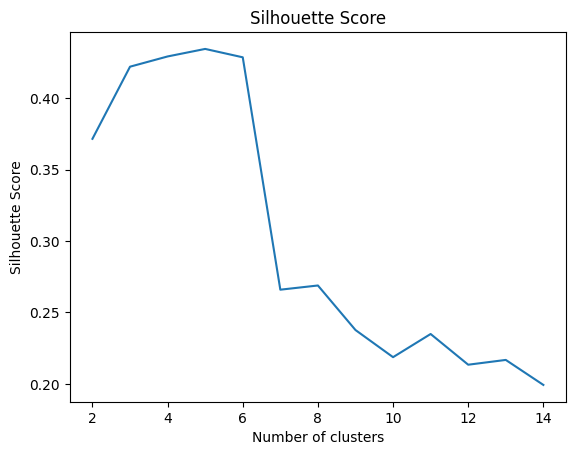

In [136]:
inertia = []

silhouette_avg = []

for i in range(1, 15):

    kmeans = KMeans(n_clusters=i, random_state=0)

    kmeans.fit(X)

    inertia.append(kmeans.inertia_)

    labels = kmeans.labels_

    centers = kmeans.cluster_centers_

    if i>1:

        silhouette_avg = silhouette_avg + [silhouette_score(X, labels)]

 

# Silhouette Score

 

plt.plot(range(1, 15), inertia)

plt.title('Elbow Method')

plt.xlabel('Number of clusters')

plt.ylabel('Inertia')

plt.show()

 

 

plt.plot(range(2, 15), silhouette_avg)

plt.title('Silhouette Score')

plt.xlabel('Number of clusters')

plt.ylabel('Silhouette Score')

plt.show()

In [137]:
k = 5
kmean = KMeans(n_clusters=k,random_state=0).fit(X)

c:\Users\srika\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


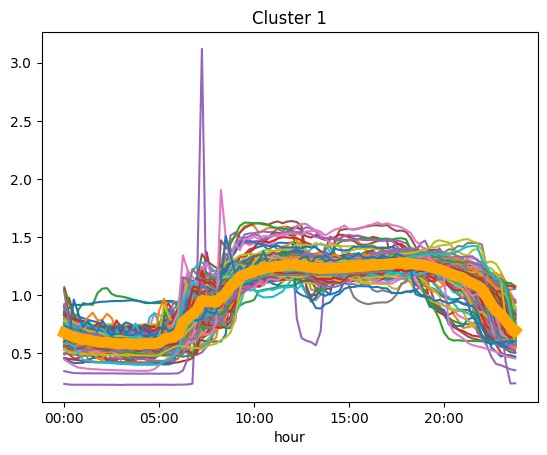

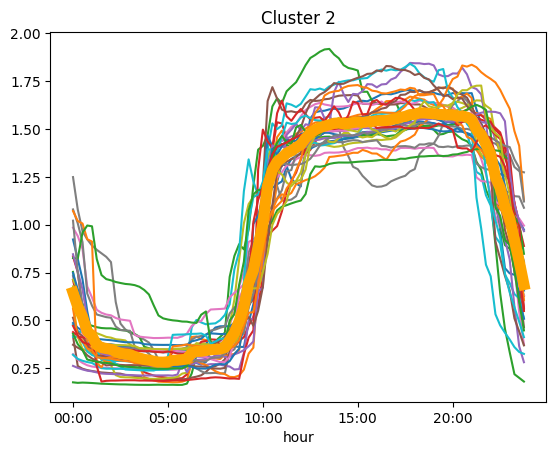

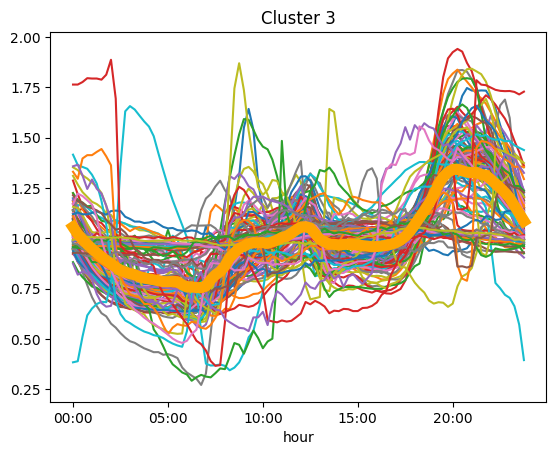

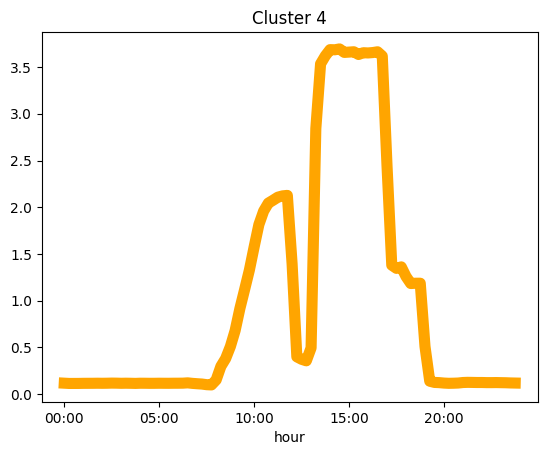

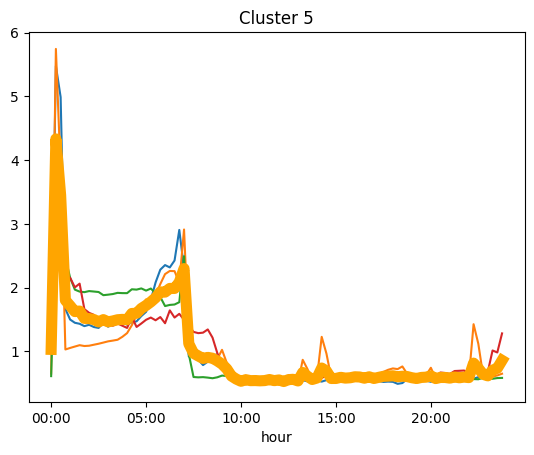

In [138]:
for c in range(k):
    average_curves_normalized.T[kmean.labels_==c].T.plot(legend=False)
    plt.plot(kmean.cluster_centers_[c],linewidth=8, color='orange')
    plt.title('Cluster {}'.format(c+1))
    plt.show()

In [139]:
oneclient = data_13_14[['MT_002']]

In [140]:
X = []

for J in range(2*365):

    X.extend([np.array(oneclient[J*96:(J+1)*96])])

In [141]:
x

[array([2253.20056899, 2184.92176387, 2184.92176387, ..., 2048.36415363,
        1980.08534851, 1980.08534851])]

In [142]:
from datetime import date, timedelta

 

d1 = date(2013,1,1)

d2 = date(2014, 12, 31)

delta = d2-d1

daysyear=[]

D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri',5:'sat', 6:'sun'}

for i in range(delta.days + 1):

    daysyear.extend([D[(d1+timedelta(days=i)).weekday()]+"-"+str(d1+timedelta(days=i))])

In [143]:
inertia_1 = []
silhouette_avg_1 = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    inertia_1.append(kmeans.inertia_)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    if i > 1:
        silhouette_avg_1.append(silhouette_score(X, labels))

# Rest of your code for plotting

plt.plot(range(1, 15), inertia_1)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

plt.plot(range(2, 15), silhouette_avg_1)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (730,) + inhomogeneous part.

In [145]:
K = 2

kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

 

# create plots

 

plt.plot(kmeans.cluster_centers_[0], linewidth=8)

plt.title("cluster "+str(0) +'num_days' + str(sum(kmeans.labels_==0)))

plt.show()

 

plt.plot(kmeans.cluster_centers_[1], linewidth=8)

plt.title("cluster "+str(1) + "num_days"+ str(sum(kmeans.labels_==1)))

plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (730,) + inhomogeneous part.

In [146]:
from itertools import compress
list(compress(clients, kmeans.labels_==1))

AttributeError: 'KMeans' object has no attribute 'labels_'